In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import csv
from scipy import stats
from numpy import genfromtxt
from scipy import signal
from scipy.fft import fft, fftfreq, ifft, next_fast_len
import pickle
from scipy.signal import blackman
from sklearn.decomposition import PCA


In [2]:
# Define the root directory and file name prefix
roots = "C:/Users/guioc/Documents/Art1/SoundSSC/Raw_Data/"
names = "LPboia02."

# Define the file extensions to be read
extensions = ['sen', 'v1', 'v2', 'v3', 'a1', 'a2', 'a3', 'wap', 'whd']

# Read each file and store the data
for ext in extensions:
    arq = np.loadtxt(roots + names + ext)  # Load the file as a NumPy array
    globals()[ext] = arq  # Dynamically assign the array to a variable named after the extension


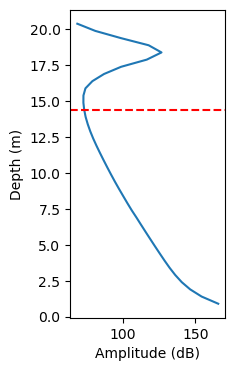

In [3]:
# Defining the cutoff line for velocity and acoustic amplitude data
z = np.array([0.90, 1.40, 1.90, 2.40, 2.90, 3.40, 3.90, 4.40, 4.90, 5.40, 5.90, 
              6.40, 6.90, 7.40, 7.90, 8.40, 8.90, 9.40, 9.90, 10.40, 10.90, 
              11.40, 11.90, 12.40, 12.90, 13.40, 13.90, 14.40, 14.90, 15.40, 
              15.90, 16.40, 16.90, 17.40, 17.90, 18.40, 18.90, 19.40, 19.90, 20.40])

# Calculating the average amplitude from the three components
amp = (a1 + a2 + a3) / 3

# Plotting the mean amplitude profile
fig, ax = plt.subplots(figsize=(2, 4), dpi=100)
ax.plot(np.nanmean(amp, axis=0), z)
plt.axhline(y=14.4, color='r', linestyle='--')  # Adding a cutoff line at 14.4 m
plt.ylabel('Depth (m)')
plt.xlabel('Amplitude (dB)')

# Cutting the data arrays to remove depths below the cutoff
v1_cut = np.delete(v1, slice(28, 40), axis=1)
v2_cut = np.delete(v2, slice(28, 40), axis=1)
v3_cut = np.delete(v3, slice(28, 40), axis=1)
a1_cut = np.delete(a1, slice(28, 40), axis=1)
a2_cut = np.delete(a2, slice(28, 40), axis=1)
a3_cut = np.delete(a3, slice(28, 40), axis=1)


Text(0.5, 0, 'Amplitude (dB)')

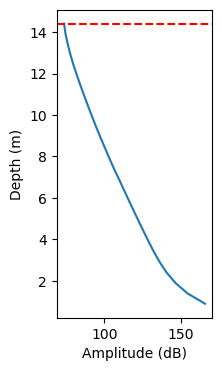

In [4]:
# Recalculating the average amplitude using the cut amplitude arrays
amp = (a1_cut + a2_cut + a3_cut) / 3

# Updating the depth array to match the cut data
z = np.array([0.90, 1.40, 1.90, 2.40, 2.90, 3.40, 3.90, 4.40, 4.90, 5.40, 5.90, 
              6.40, 6.90, 7.40, 7.90, 8.40, 8.90, 9.40, 9.90, 10.40, 10.90, 
              11.40, 11.90, 12.40, 12.90, 13.40, 13.90, 14.40])

# Plotting the mean amplitude profile
fig, ax = plt.subplots(figsize=(2, 4), dpi=100)
ax.plot(np.nanmean(amp, axis=0), z)  # Mean amplitude along the depth
plt.axhline(y=14.4, color='r', linestyle='--')  # Indicating cutoff depth
plt.ylabel('Depth (m)')
plt.xlabel("Amplitude (dB)")


In [5]:
# Initialize lists for datetime objects and timestamps
time = []  # To store datetime objects
time_II = []  # To store timestamps

# Extract pressure data from the `sen` array and compute depth
db = sen[:, 13]  # Pressure in decibar
depth = ((db * 10000) / (1021.32 * 9.79499))  # Convert pressure to depth (m)

# Loop through the `sen` array to extract and convert time
for i in range(len(sen[:, 2])):
    # Create a datetime object from the array's time information
    tsh_tempo = datetime.datetime(int(sen[i, 2]),  # Year
                                  int(sen[i, 0]),  # Month
                                  int(sen[i, 1]),  # Day
                                  int(sen[i, 3]),  # Hour
                                  int(sen[i, 4]),  # Minute
                                  int(sen[i, 5]))  # Second
    # Convert the datetime object to a timestamp for interpolation
    tsh_tempo_II = datetime.datetime.timestamp(tsh_tempo)
    
    # Append the datetime and timestamp to their respective lists
    time.append(tsh_tempo)
    time_II.append(tsh_tempo_II)


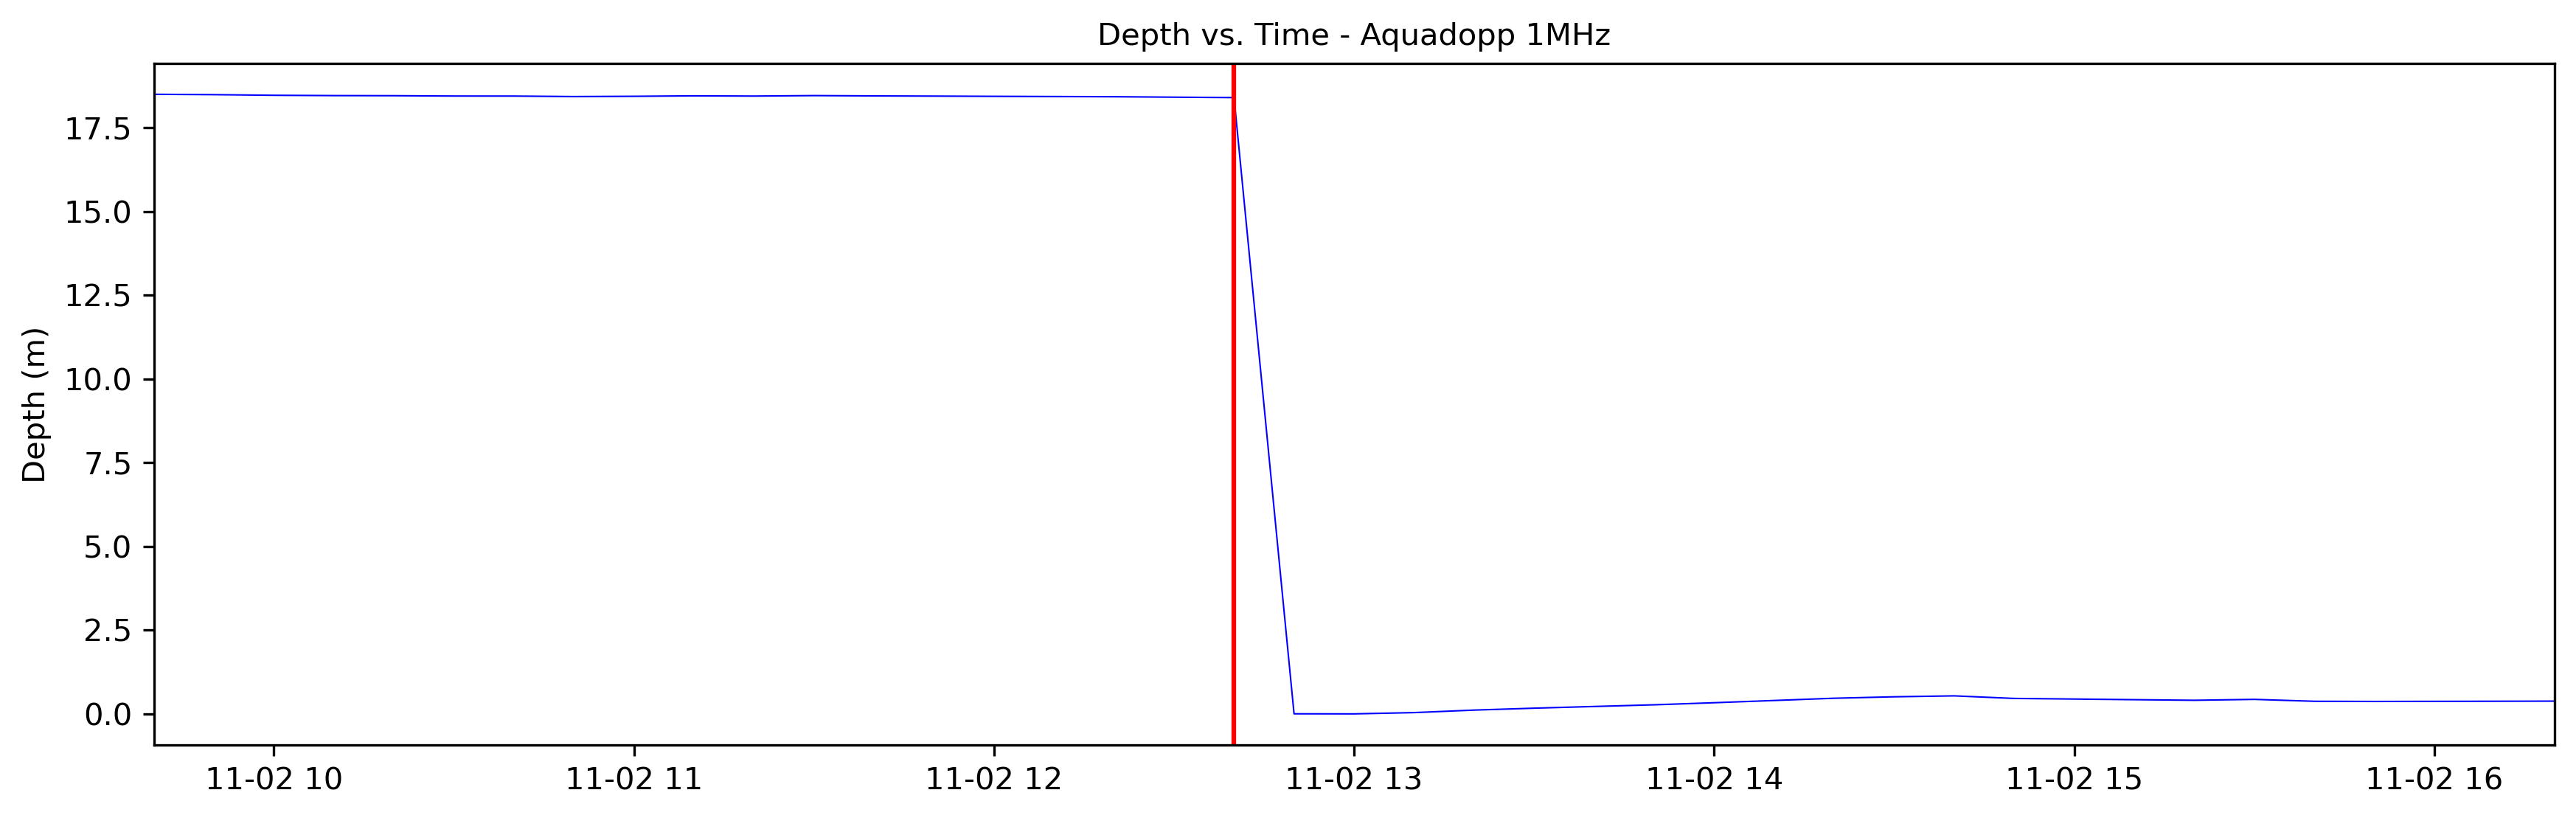

In [6]:
# Plotting depth vs. time to identify when the ADCP was out of water
fig, ax = plt.subplots(figsize=(14, 4), dpi=300)

# Plot depth data for the specified range of indices
ax.plot(time[6610:6651], depth[6610:6651], color='b', linewidth=0.5)

# Title and axis labels
plt.title("Depth vs. Time - Aquadopp 1MHz", fontsize=10)
ax.set_ylabel('Depth (m)')

# Set x-axis limits to focus on the specified time range
ax.set_xlim(np.nanmin(time[6610:6651]), np.nanmax(time[6610:6651]))

# Add a vertical red line to mark the cutoff index
ax.axvline(x=time[6628], color='r')



(18522.5, 18568.520833333332)

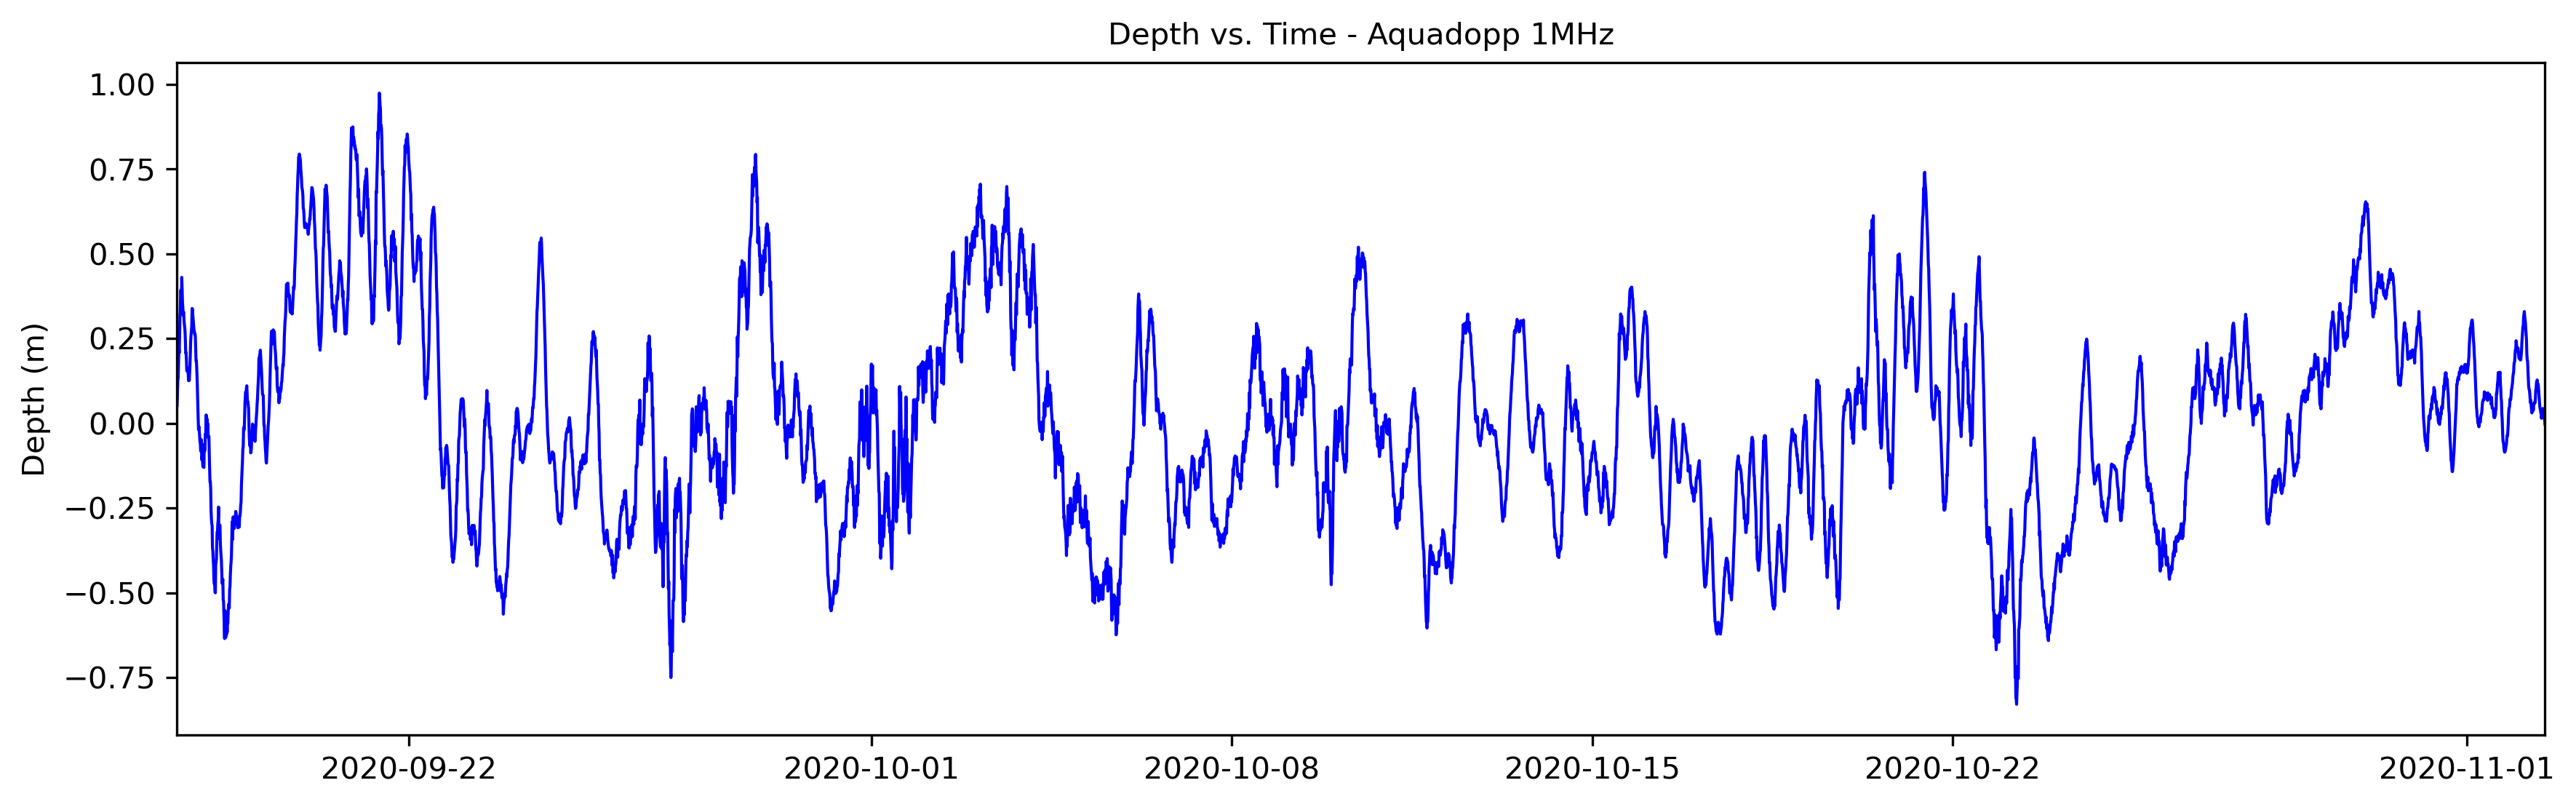

In [7]:
# Plotting depth vs. time for the period before the ADCP went out of water (index 6628)
fig, ax = plt.subplots(figsize=(14, 4), dpi=300)

# Plot depth data, adjusted by subtracting the mean depth to normalize
ax.plot(time[0:6628], depth[0:6628] - np.nanmean(depth[0:6628]), color='b', linewidth=1)

# Title and axis labels
plt.title("Depth vs. Time - Aquadopp 1MHz", fontsize=10)
ax.set_ylabel('Depth (m)')

# Set x-axis limits based on the specified time range
ax.set_xlim(np.nanmin(time[0:6628]), np.nanmax(time[0:6628]))


Angle with true north: -63.24 degrees


Text(0.5, 1.0, 'PCA of U and V Components')

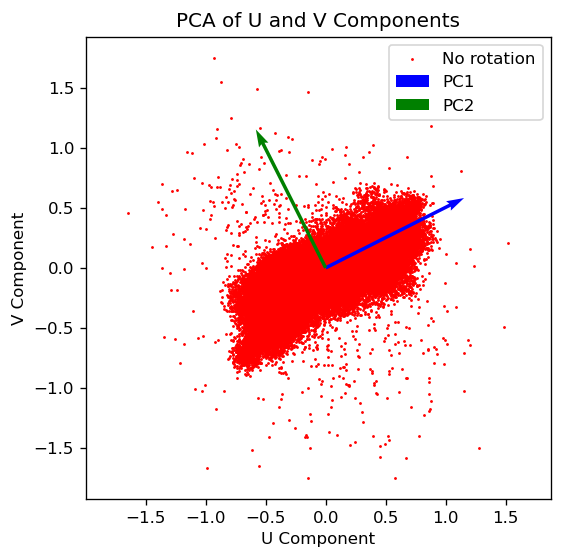

In [8]:
# Assuming v1_cut and v2_cut are numpy arrays
v1 = v1_cut.flatten()  # Flattening the array, adjust indices if necessary
v2 = v2_cut.flatten()  # Flattening the array, adjust indices if necessary

# Organizing the data for PCA
data = np.vstack((v1, v2)).T

# Applying PCA
pca = PCA(n_components=2)
pca.fit(data)
components = pca.components_

# Principal components
pc1 = components[0]
pc2 = components[1]

# Calculating the angle between the first principal component and true north (y-axis)
angle_with_north = np.arctan2(pc1[1], pc1[0])  # In radians
angle_with_north_deg = np.degrees(angle_with_north) - 90  # Converting to degrees and adjusting for true north

print(f"Angle with true north: {angle_with_north_deg:.2f} degrees")


fig, ax = plt.subplots(figsize=(5,5), dpi = 120)

# Plotting the data
ax.scatter(v1, v2, c='r', s=0.5, label='No rotation')

# Plotting the principal components
origin = [0], [0]  # Origin for the vectors
ax.quiver(*origin, *pc1, color='b', scale=3, label='PC1')
ax.quiver(*origin, *pc2, color='g', scale=3, label='PC2')
ax.axis('equal')
ax.set_xlabel('U Component')
ax.set_ylabel('V Component')
ax.legend()
ax.set_title('PCA of U and V Components')




In [9]:
# Calculate the magnitude of the velocity vector M
M = np.sqrt(v1_cut**2 + v2_cut**2)

# Calculate the direction (angle) of the velocity vector in radians using arctan2
UV_dir = np.arctan2(v2_cut/M, v1_cut/M)

# Convert direction from radians to degrees
UV_dir_degrees = np.rad2deg(UV_dir)%360

# Initialize empty arrays to store the rotated U and V components
U_spin = np.zeros((len(M), len(z[:])))  
V_spin = np.zeros((len(M), len(z[:])))

# Loop through the velocity data and rotate it by 63.24 degrees
for i in range(len(z[0:28])): 
    for j in range(len(M)):  
        if M[j, i] != 0:  # Avoid division by zero
            rot_ang = (UV_dir_degrees[j, i] + 63.24) % 360

            # Calculate the new U and V components after rotation
            V_spin[j, i] = M[j, i] * np.cos(np.radians(rot_ang))
            U_spin[j, i] = M[j, i] * np.sin(np.radians(rot_ang))


C:\Users\guioc\AppData\Local\Temp\ipykernel_64260\2306411012.py:5: RuntimeWarning: invalid value encountered in divide
  UV_dir = np.arctan2(v2_cut/M, v1_cut/M)


C:\Users\guioc\AppData\Local\Temp\ipykernel_64260\1635729949.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(v1_cut,v2_cut,c = 'r',cmap=plt.cm.jet, s = 0.5, label = 'with rotation')
C:\Users\guioc\AppData\Local\Temp\ipykernel_64260\1635729949.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(V_spin,U_spin,c = 'b',cmap=plt.cm.jet, s = 0.5, label = 'no rotation')


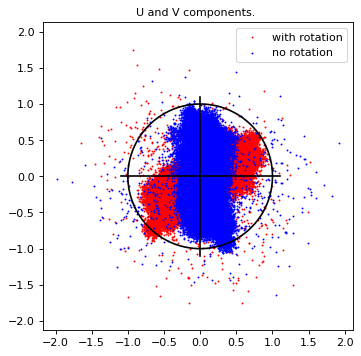

In [10]:
#Comparando os dados de vel. brutos com os dados rotacionados. 
fig, ax = plt.subplots(figsize=(5,5), dpi = 80)
n = np.linspace(0, 2*np.pi, 100)
circ_x = np.sin(n)
circ_y = np.cos(n)
ax.plot(circ_x, circ_y,'k')
ax.plot([0,0], [-1.1, 1.1], 'k')
ax.plot([-1.1, 1.1], [0, 0], 'k')
ax.axis('equal')
M = np.sqrt(V_spin**2+U_spin**2)
plt.title("U and V components. ", fontsize=10)
ax.scatter(v1_cut,v2_cut,c = 'r',cmap=plt.cm.jet, s = 0.5, label = 'with rotation')
ax.scatter(V_spin,U_spin,c = 'b',cmap=plt.cm.jet, s = 0.5, label = 'no rotation')
ax.legend()

In [11]:
# Converting the acoustic amplitude obtained by the ADCP to acoustic backscatter
# Ref: 10.1016/j.margeo.2004.07.001
amp = (a1_cut + a2_cut + a3_cut) / 3
deg_sensor = 25  # Acoustic beam angle relative to vertical
dist_feixe = z / np.cos(deg_sensor * np.pi / 180)
alpha = 0.34  # http://resource.npl.co.uk/acoustics/techguides/seaabsorption/
correcao_geometrica = 20 * np.log10(dist_feixe)
correcao_absorcao = 2 * alpha * dist_feixe
# Acoustic backscatter (dB)
rea = 0.42 * (amp - 20) + correcao_geometrica + correcao_absorcao

# Calibration obtained from the article (Schettini 2013).
# Ref: https://doi.org/10.1016/j.csr.2013.03.006
ssc = -1.05 + 1.03 * np.exp(-7.608 + 0.1989 * rea)


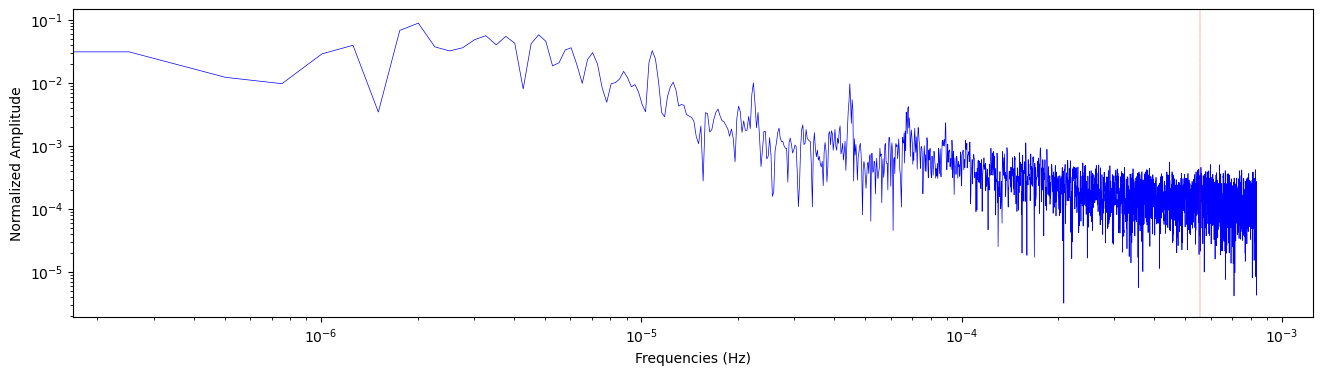

In [12]:
# Defining the cutoff frequency for the FFT filter.
trashU = np.nanmean(U_spin[0:6628], 1)
n = len(trashU)
w = blackman(n)
t = 600
yf = fft(trashU * w)
xf = fftfreq(n, t)
yf = yf[0:n//2]
xf = xf[:n//2]
yf = 2.0 / n * np.abs(yf)

plt.figure(figsize=(16, 4))
plt.loglog(xf, yf, color='b', linewidth=0.5)
plt.xlabel('Frequencies (Hz)')
plt.ylabel('Normalized Amplitude')
plt.axvline(x=1 / 1800, color='r', linestyle='--', linewidth=0.3)


In [13]:
fs = 1 / 600  # Sampling frequency
fc = 1 / 9000  # Cut-off frequency of the filter
w = fc / (fs / 2)  # Normalize the frequency

# Low frequency filter
b, a = signal.butter(6, w, 'low')
U_fft = np.zeros((len(time[0:6628]), len(z)))
U_fft_filt = np.zeros((len(time[0:6628]), len(z)))

for i in range(len(z[0:28])):
    U_fft[:, i] = signal.filtfilt(b, a, U_spin[0:6628, i])

# High frequency filter
b, a = signal.butter(5, w, 'high')
for i in range(len(z[0:28])):
    U_fft_filt[:, i] = signal.filtfilt(b, a, U_spin[0:6628, i])


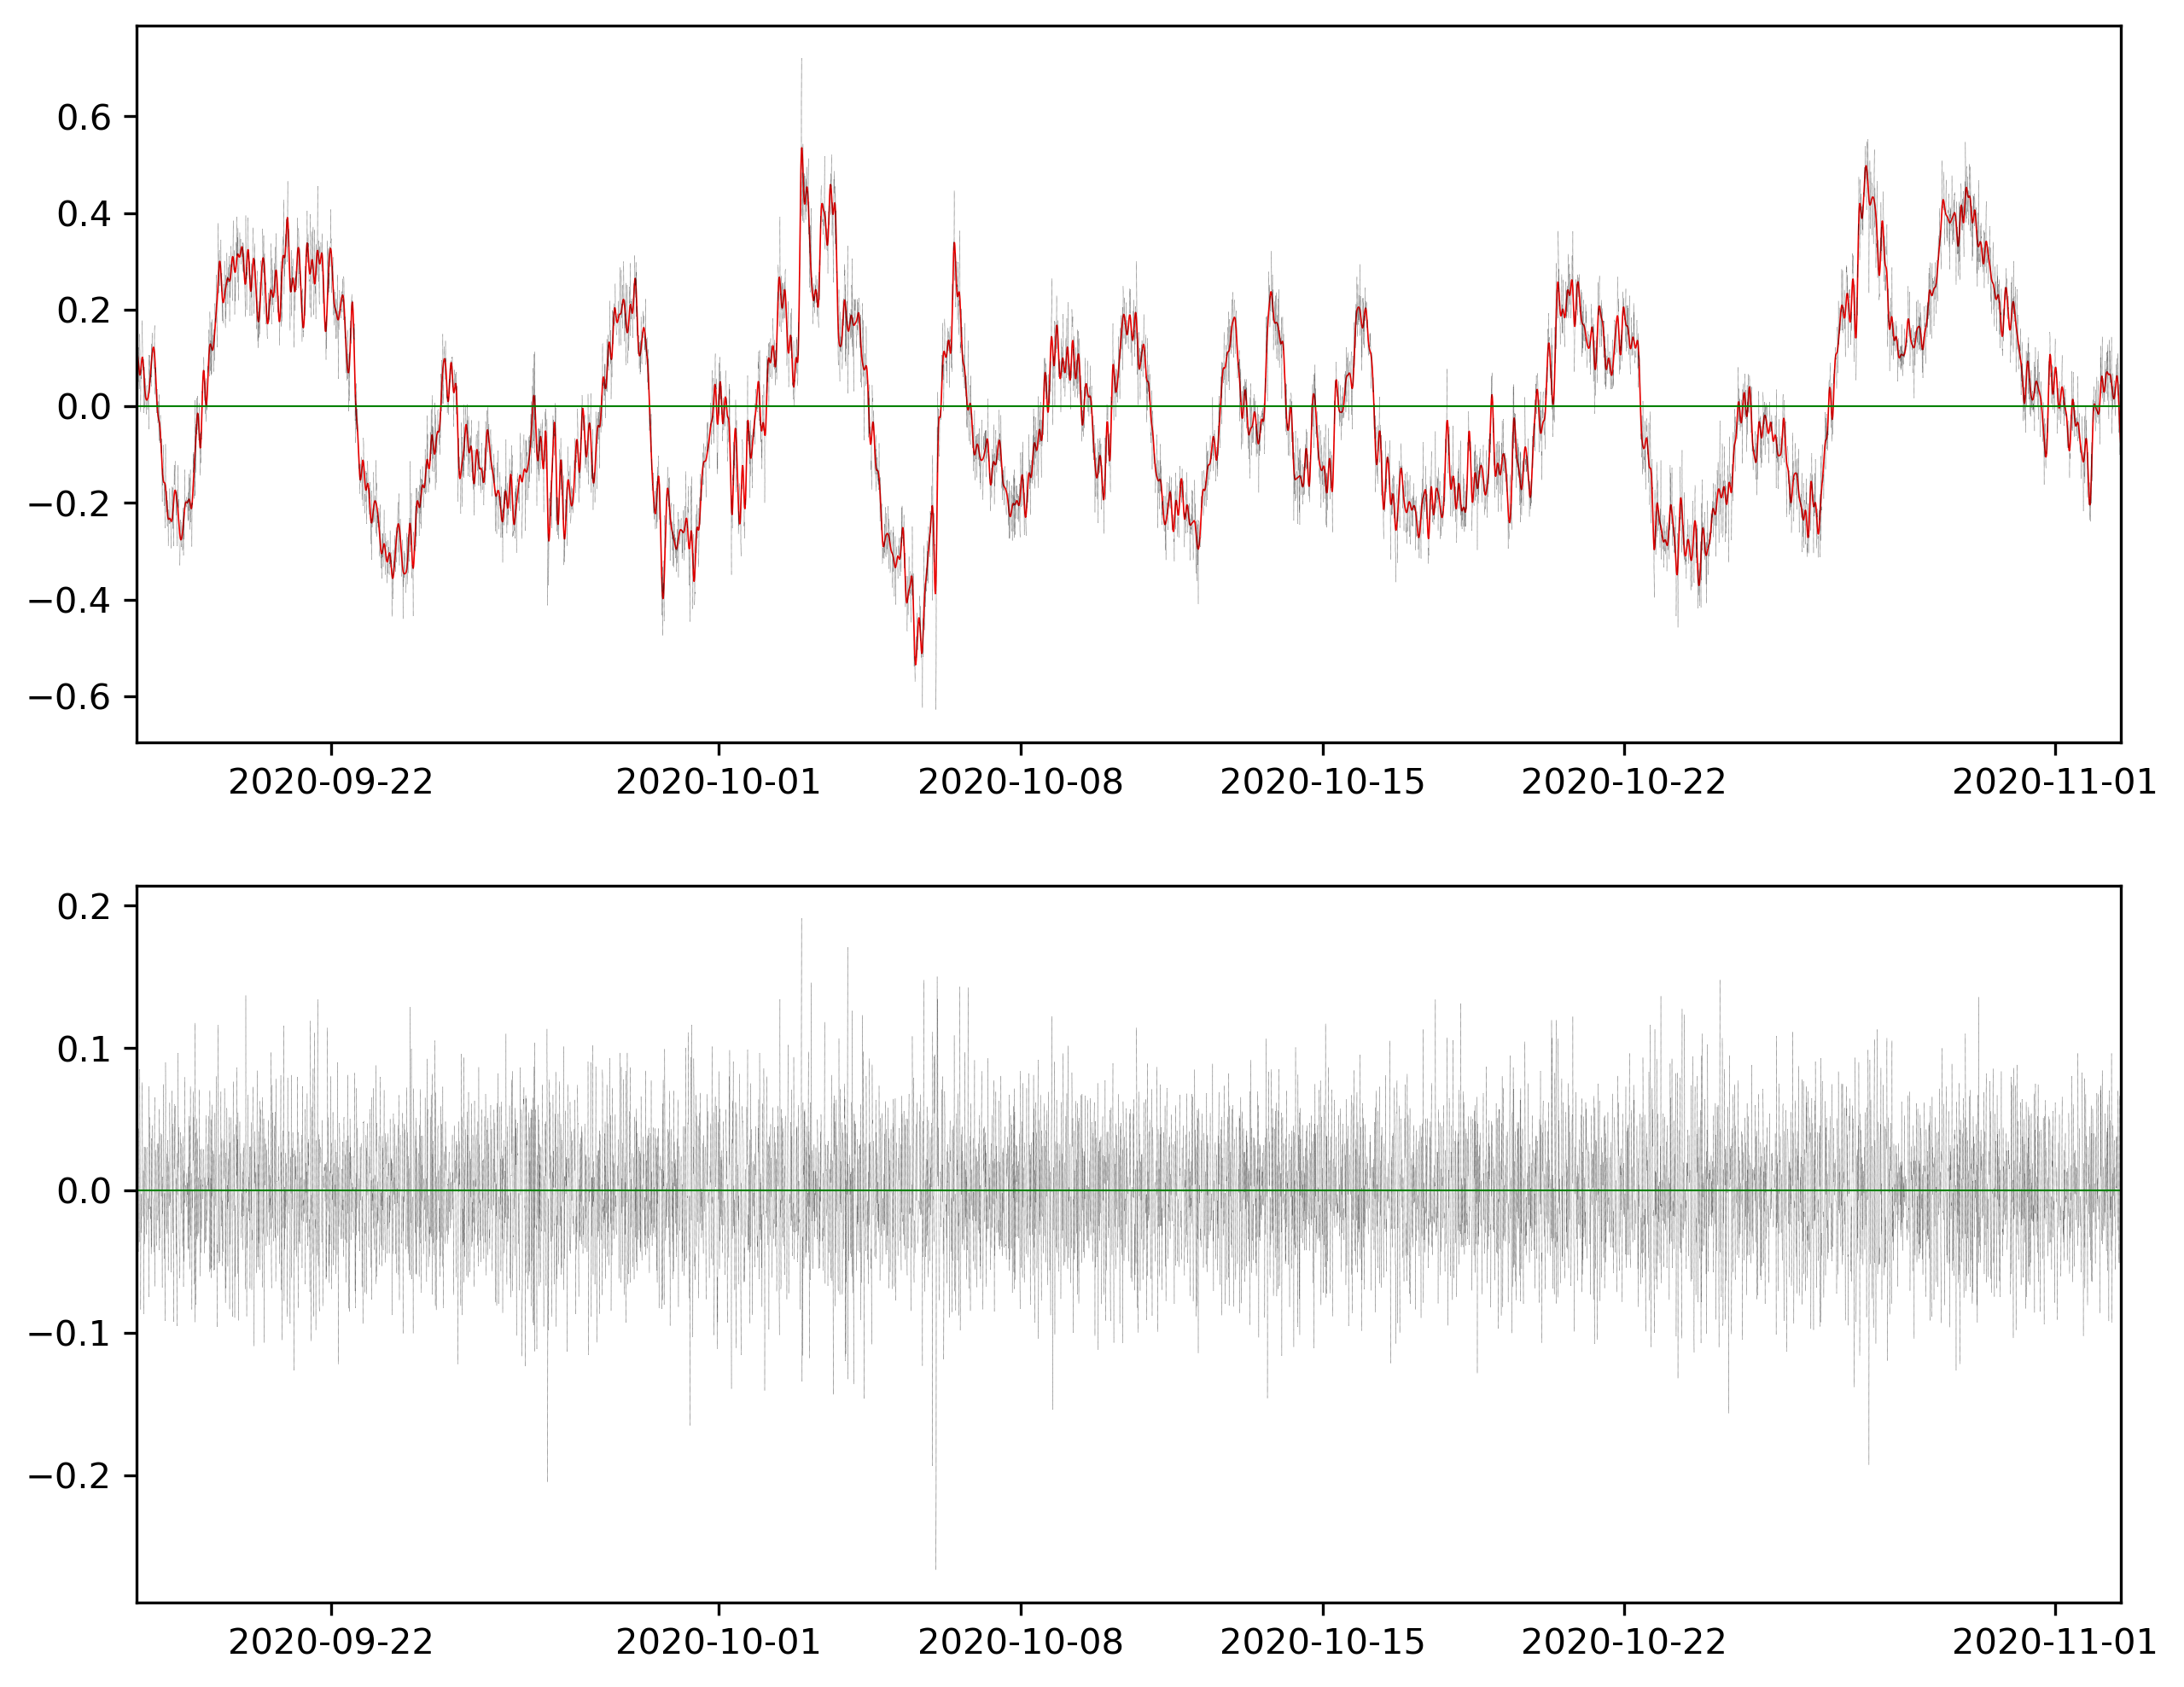

In [14]:
fig, ax = plt.subplots(2,1,figsize=(10,8), dpi = 300)

ax[0].plot(time[0:6628],U_fft[:,0],linewidth = 0.4,color =  'r')
ax[0].plot(time[0:6628],U_spin[0:6628,0],':',linewidth = 0.1, color = 'k')
ax[0].set_xlim(np.min(time[0:6628]), np.max(time[0:6628]))
ax[0].axhline(y= 0, color='g', linewidth = 0.5)

ax[1].plot(time[0:6628],U_fft_filt[0:6628,0],':',linewidth = 0.1, color = 'k')
ax[1].set_xlim(np.min(time[0:6628]), np.max(time[0:6628]))
ax[1].axhline(y= 0, color='g', linewidth = 0.5)

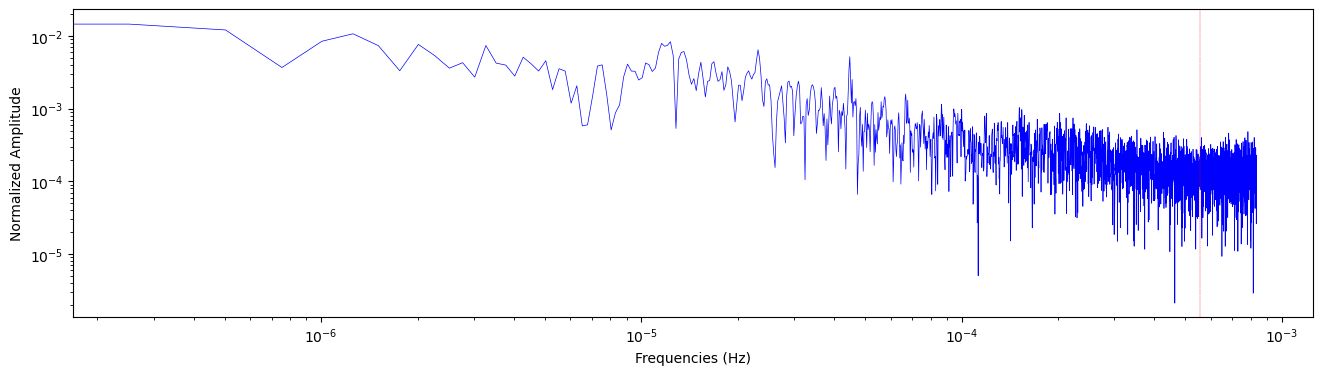

In [15]:
# Defining the cutoff frequency for the FFT filter.
trashV = np.nanmean(V_spin[0:6628], 1)
n = len(trashV)#
w = blackman(n)
t = 600
yf = fft(trashV*w)
xf = fftfreq(n, t)
yf = yf[0:n//2]
xf = xf[:n//2]
yf = 2.0/n * np.abs(yf)

plt.figure(figsize=(16,4))
plt.loglog((xf),(yf), color = 'b', linewidth = 0.5)
plt.xlabel('Frequencies (Hz)')
plt.ylabel('Normalized Amplitude')
plt.axvline(x= 1/1800, color='r', linestyle='--', linewidth = 0.3)

In [16]:
fs = 1/600  #frequencia amostral
fc = 1/9000  # Cut-off frequency of the filter (frequencia de corte)
w = fc / (fs / 2) # Normalize the frequency
#low frequency
b, a = signal.butter(5, w, 'low') 
V_fft = np.zeros((len(time[0:6628]), len(z)))
V_fft_filt = np.zeros((len(time[0:6628]), len(z)))

for i in range(len(z[0:28])):
    V_fft[:,i] = signal.filtfilt(b, a, V_spin[0:6628, i])
    
#high frequency
b, a = signal.butter(5, w, 'high') 
for i in range(len(z[0:28])):
    V_fft_filt[:,i] = signal.filtfilt(b, a, V_spin[0:6628, i])

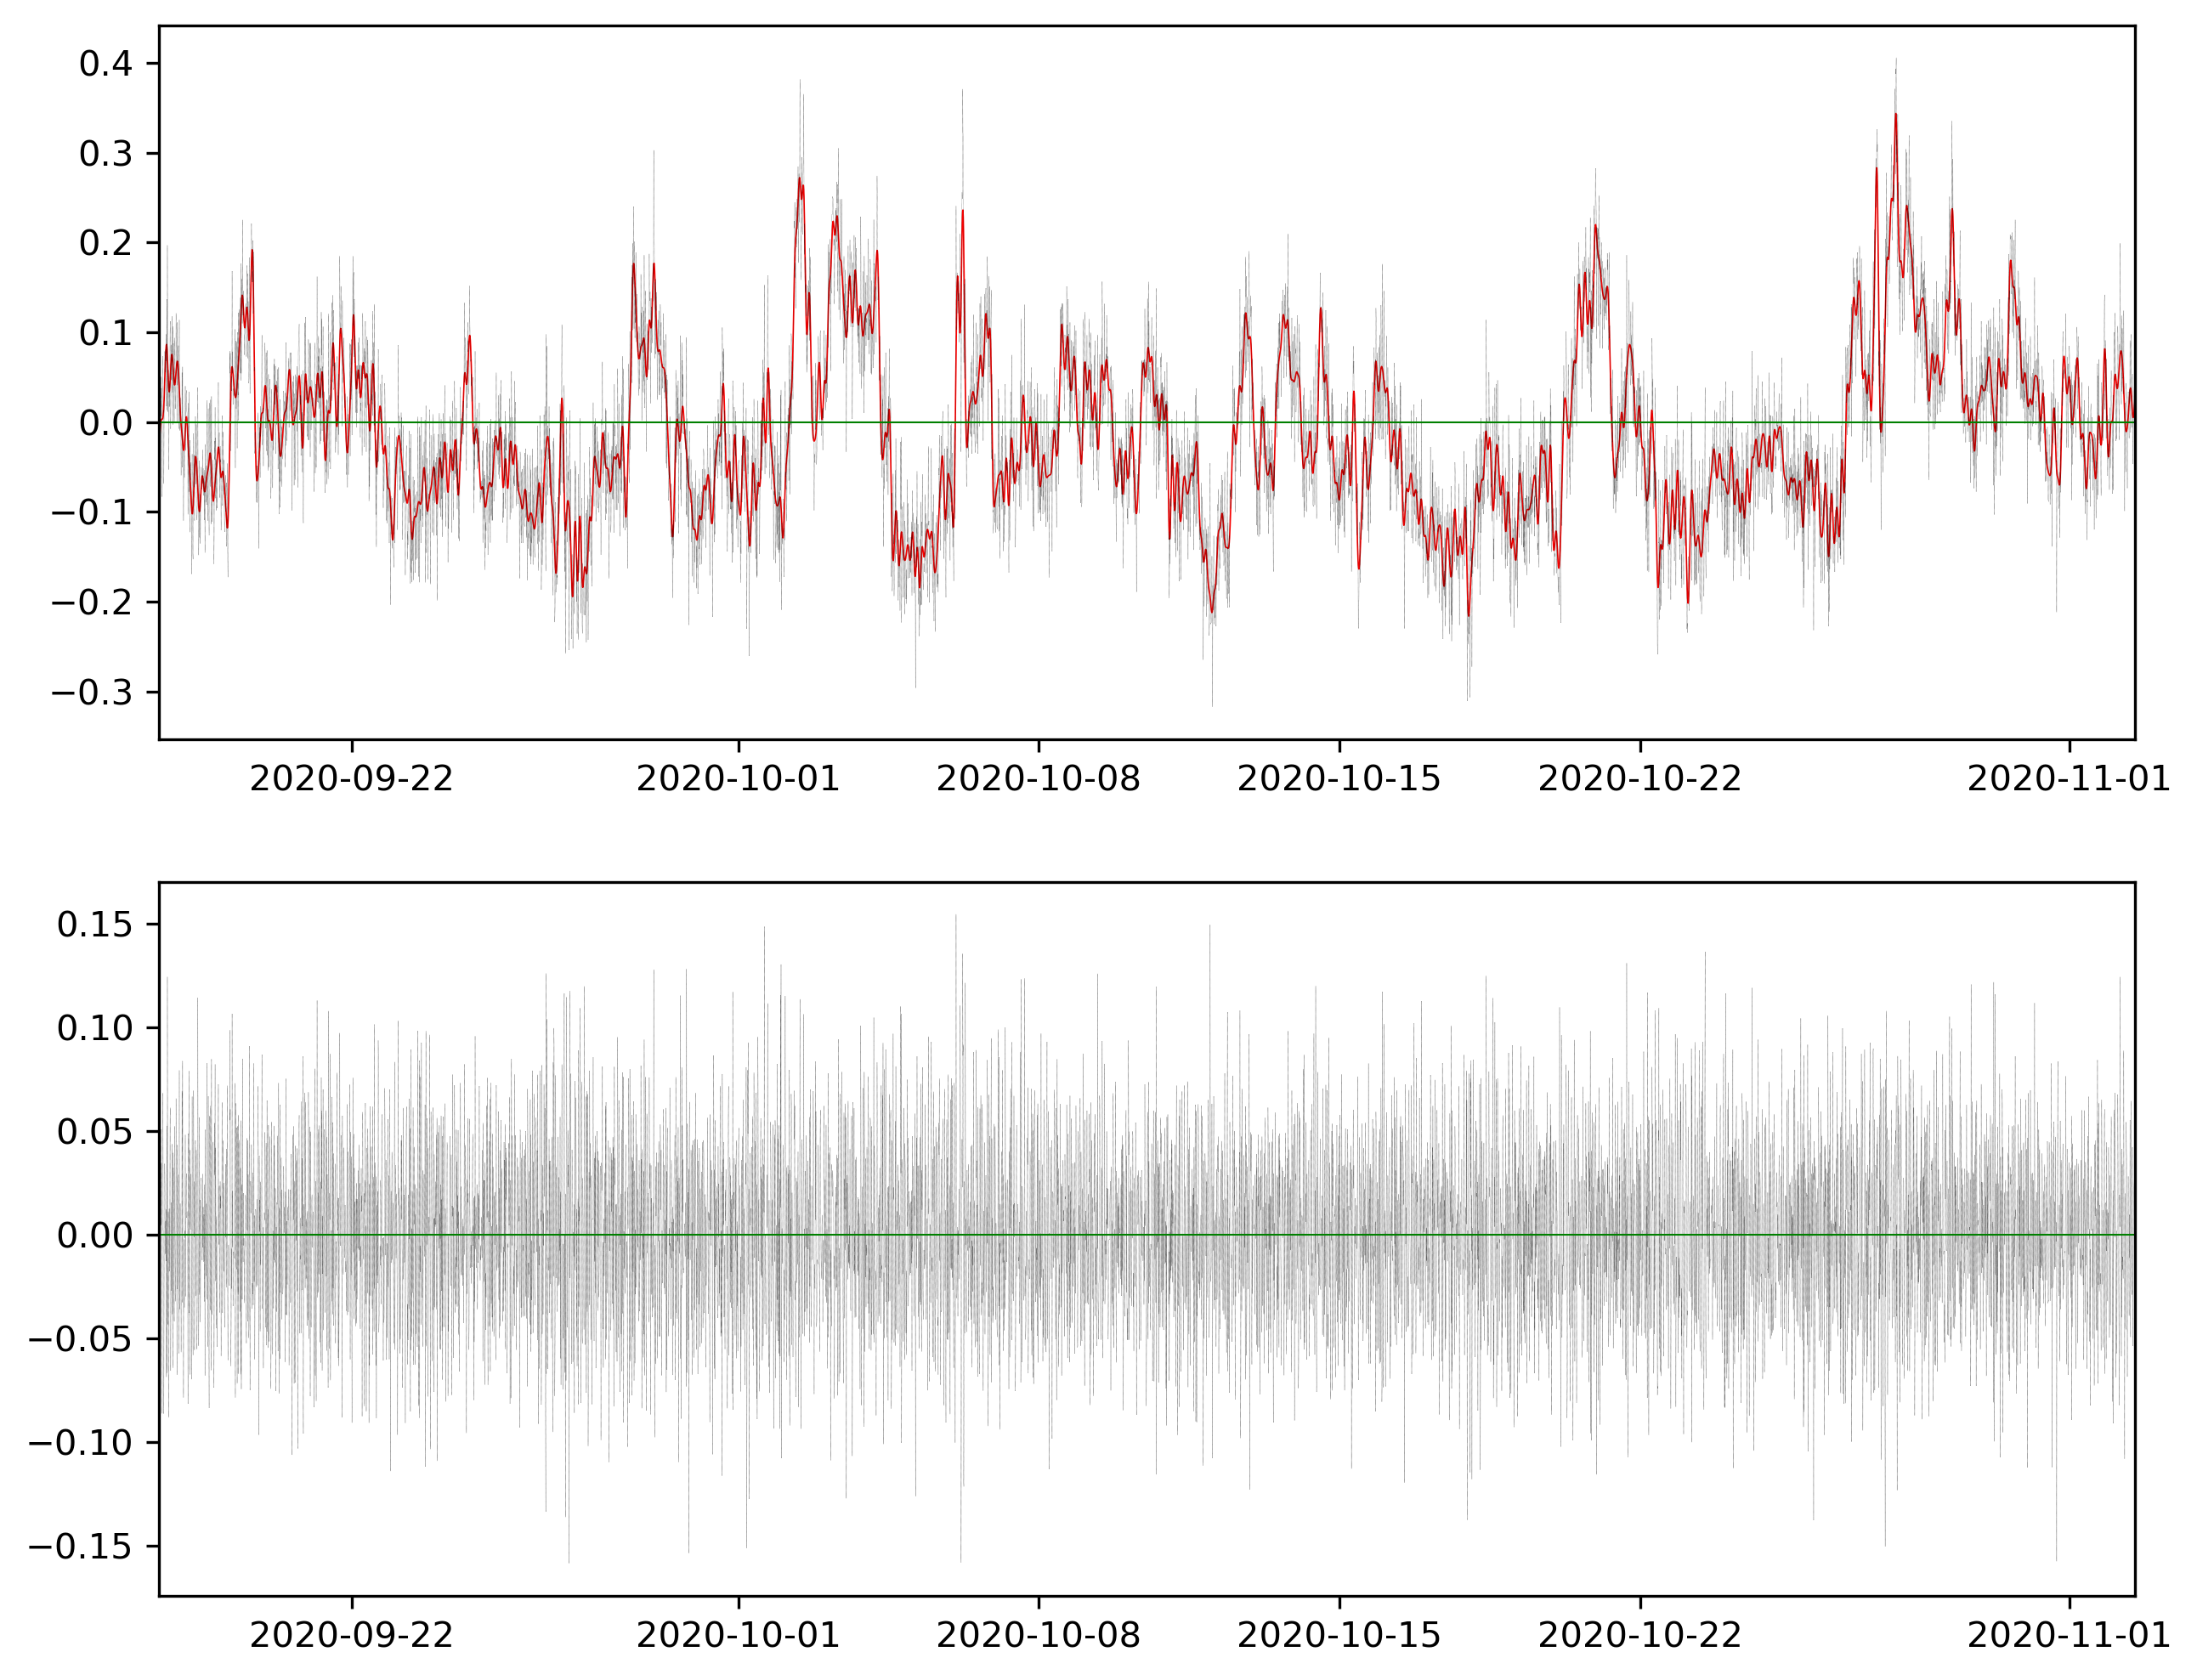

In [17]:
fig, ax = plt.subplots(2,1,figsize=(10,8), dpi = 300)

ax[0].plot(time[0:6628],V_fft[:,0],linewidth = 0.4,color =  'r')
ax[0].plot(time[0:6628],V_spin[0:6628,0],':',linewidth = 0.1, color = 'k')
ax[0].set_xlim(np.min(time[0:6628]), np.max(time[0:6628]))
ax[0].axhline(y= 0, color='g', linewidth = 0.5)

ax[1].plot(time[0:6628],V_fft_filt[0:6628,0],':',linewidth = 0.1, color = 'k')
ax[1].set_xlim(np.min(time[0:6628]), np.max(time[0:6628]))
ax[1].axhline(y= 0, color='g', linewidth = 0.5)

In [18]:
# Saving processed data
roots = "C:/Users/guioc/Documents/Art1/SoundSSC/Output_Data/"

# Saving filtered velocity data in U and V components
with open(roots + 'U_fft.pkl', 'wb') as file:  # Processed V component velocity data after FFT filtering
    pickle.dump(V_fft, file)

with open(roots + 'V_fft.pkl', 'wb') as file:  # Processed U component velocity data after FFT filtering
    pickle.dump(U_fft, file)

# Saving raw velocity data before filtering (spin components)
with open(roots + 'U_raw.pkl', 'wb') as file:  # Raw V component velocity data (before filtering)
    pickle.dump(V_spin[0:6628, :], file)

with open(roots + 'V_raw.pkl', 'wb') as file:  # Raw U component velocity data (before filtering)
    pickle.dump(U_spin[0:6628, :], file)

# Saving time data
with open(roots + 'Time_fft.pkl', 'wb') as file:  # Time stamps (in original format) for filtered data
    pickle.dump(time[0:6628], file)

with open(roots + 'Time_II_fft.pkl', 'wb') as file:  # Time stamps (as UNIX timestamps) for filtered data
    pickle.dump(time_II[0:6628], file)

# Saving acoustic backscatter data and sediment concentration
with open(roots + 'REA.pkl', 'wb') as file:  # Acoustic backscatter data (REA) calculated from the ADCP amplitude
    pickle.dump(rea[0:6628], file)

with open(roots + 'SSC_rea.pkl', 'wb') as file:  # Sediment Suspended Concentration (SSC) based on REA (from calibration)
    pickle.dump(ssc[0:6628], file)

# Saving depth data
with open(roots + 'depth.pkl', 'wb') as file:  # Depth data corresponding to the ADCP measurements
    pickle.dump(depth[0:6628], file)

# Saving temperature and pressure data from the ADCP sensor
with open(roots + 'temp_ADCP.pkl', 'wb') as file:  # Temperature measurements from the ADCP sensor
    pickle.dump(sen[0:6628, 14], file)

with open(roots + 'pressure_ADCP.pkl', 'wb') as file:  # Pressure measurements from the ADCP sensor
    pickle.dump(sen[0:6628, 13], file)
